<a href="https://colab.research.google.com/github/Mingrui-Wang/Inverse-of-a-Matrix/blob/master/double_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/暑期科研/"

os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['9total_y.npy',
 '9total_x.npy',
 'normal_hard.npy',
 'normal_hard_label.npy',
 'N_A_H_label.npy',
 'N_A_H.npy',
 'Anomaly_label.npy',
 'Anomaly.npy',
 'chromosome_9_label.npy',
 'chromosome_9.npy',
 'chromosome_harddata_label.npy',
 'chromosome_harddata.npy',
 'my_model.h5',
 '测试集_label.npy',
 '测试集.npy',
 '训练集_label.npy',
 '训练集.npy',
 '训练集500_label.npy',
 '训练集500.npy',
 '训练集400.npy',
 '训练集400_label.npy',
 '训练集300_label.npy',
 '训练集300.npy']

In [2]:
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D
import os

x_train_savepath = './训练集300.npy'
y_train_savepath = './训练集300_label.npy'

print('-------------Load Datasets-----------------')
x_train = np.load(x_train_savepath)
y_train = np.load(y_train_savepath)

x_train = x_train.astype('float32')
print(x_train.shape)

-------------Load Datasets-----------------
(643, 22500)


In [3]:
x_test = x_train[468:643]
x_train_new = x_train[0:468]
x_train = x_train_new
len(x_test)

175

In [4]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras import Model

np.set_printoptions(threshold=np.inf)

x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(x_train.shape[0], 150, 150, 1)  # 给数据增加一个维度，使数据和网络结构匹配
x_test = x_test.reshape(x_test.shape[0], 150, 150, 1)  # 给数据增加一个维度，使数据和网络结构匹配


print("x_train.shape", x_train.shape)
print("x_test.shape", x_test.shape)

x_train.shape (468, 150, 150, 1)
x_test.shape (175, 150, 150, 1)


In [5]:
class Autoencoder():
    def __init__(self):

        self.img_shape = (150,150,1)

        optimizer = Adam(lr=0.001)

        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='binary_crossentropy', optimizer=optimizer)
        self.autoencoder_model.summary()

    def build_model(self):
        input_layer = Input(shape=self.img_shape)

        # encoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
        h = MaxPooling2D((2, 2), padding='same')(h)
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = MaxPooling2D((3, 3), padding='same')(h)

        # decoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((3, 3))(h)
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((2, 2))(h)

        output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h)

        return Model(input_layer, output_layer)

    def train_model(self, x_train, y_train, x_test, y_test, epochs, batch_size):
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1,
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, x_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_test, x_test),
                                             callbacks=[early_stopping])
        
        file = self.autoencoder_model.save_weights('my_model.h5')

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 75, 75, 64)       

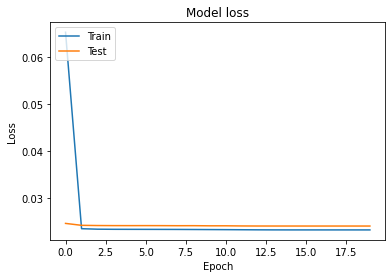

In [6]:
ae = Autoencoder()
ae.train_model(x_train, x_train, x_test, x_test, epochs=20, batch_size=3)

In [7]:
decoded_test = ae.eval_model(x_test)
### get the error term of all testing dataset images
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
#scale it
scaled_input_test = scaler.fit_transform(x_test.reshape(-1,22500))
#scale it
scaled_output_test = scaler.fit_transform(decoded_test.reshape(-1,22500))

In [8]:
### get the error term of all training set images

# Firstly, we get the decoder image of training set.
decoded_train = ae.eval_model(x_train)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
#scale it
scaled_input_train = scaler.fit_transform(x_train.reshape(-1,22500))
#scale it
scaled_output_train = scaler.fit_transform(decoded_train.reshape(-1,22500))

In [9]:
import pandas as pd
sequences = range(1,644)
from keras import losses
x = losses.binary_crossentropy(scaled_input_train,scaled_output_train)
y = losses.binary_crossentropy(scaled_input_test,scaled_output_test)

In [10]:
seqs_ds = pd.DataFrame(sequences)
mse = np.append(x,y)
seqs_ds['binary_crossentropy'] = mse
seqs_ds

,0,binary_crossentropy
0,1,1.822576
1,2,1.827692
2,3,1.796967
3,4,1.814368
4,5,1.881199
...,...,...
638,639,2.602739
639,640,2.811854
640,641,3.477071
641,642,2.319051


In [11]:
threshold = len(x_train)/(len(x_train)+len(x_test))
threshold

0.7278382581648523

In [12]:
binary_crossentropy_threshold = np.quantile(seqs_ds['binary_crossentropy'], threshold)
print(f'binary_crossentropy threshhold:{binary_crossentropy_threshold}')

binary_crossentropy threshhold:2.1345039911996886


In [13]:
seqs_ds['binary_crossentropy_Outlier'] = 0
seqs_ds.loc[seqs_ds['binary_crossentropy'] > binary_crossentropy_threshold, 'binary_crossentropy_Outlier'] = 1
print(f"Num of binary_crossentropy outlier:{seqs_ds['binary_crossentropy_Outlier'].sum()}")

seqs_ds[seqs_ds['binary_crossentropy_Outlier']==1]

Num of binary_crossentropy outlier:175


,0,binary_crossentropy,binary_crossentropy_Outlier
457,458,2.176863,1
458,459,2.225432,1
469,470,3.400373,1
470,471,3.474708,1
471,472,3.355517,1
...,...,...,...
638,639,2.602739,1
639,640,2.811854,1
640,641,3.477071,1
641,642,2.319051,1


In [19]:
x_train_savepath = './N_A_H.npy'
y_train_savepath = './N_A_H_label.npy'

print('-------------Load Datasets-----------------')
x_train = np.load(x_train_savepath)
y_train = np.load(y_train_savepath)

x_train = x_train.astype('float32')
print(x_train.shape)

-------------Load Datasets-----------------
(2359, 22500)


In [20]:
x_train = np.reshape(x_train, (len(x_train), 150, 150,1))
x_train = x_train / 255.0
x_train = x_train.astype('float32')
print(x_train.shape)

(2359, 150, 150, 1)


In [21]:
### get the error term of all training set images

# Firstly, we get the decoder image of training set.
decoded_train = ae.eval_model(x_train)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
#scale it
scaled_input_train = scaler.fit_transform(x_train.reshape(-1,22500))
#scale it
scaled_output_train = scaler.fit_transform(decoded_train.reshape(-1,22500))

import pandas as pd
sequences = range(1,2360)
from keras import losses
x = losses.binary_crossentropy(scaled_input_train,scaled_output_train)

In [22]:
seqs_ds = pd.DataFrame(sequences)
seqs_ds['binary_crossentropy'] = x
seqs_ds

,0,binary_crossentropy
0,1,1.807528
1,2,1.799743
2,3,1.814137
3,4,1.811338
4,5,1.771123
...,...,...
2354,2355,2.214394
2355,2356,2.109753
2356,2357,2.119519
2357,2358,2.038237


In [25]:
threshold = 2164/2359

binary_crossentropy_threshold = np.quantile(seqs_ds['binary_crossentropy'], threshold)
print(f'binary_crossentropy threshhold:{binary_crossentropy_threshold}')

seqs_ds['binary_crossentropy_Outlier'] = 0
seqs_ds.loc[seqs_ds['binary_crossentropy'] > binary_crossentropy_threshold, 'binary_crossentropy_Outlier'] = 1

print(f"Num of binary_crossentropy outlier:{seqs_ds['binary_crossentropy_Outlier'].sum()}")

seqs_ds[seqs_ds['binary_crossentropy_Outlier']==1]

binary_crossentropy threshhold:1.8151640740932675
Num of binary_crossentropy outlier:195


,0,binary_crossentropy,binary_crossentropy_Outlier
29,30,1.866191,1
37,38,1.822661,1
50,51,1.829268,1
64,65,1.825201,1
92,93,1.819275,1
...,...,...,...
2354,2355,2.214394,1
2355,2356,2.109753,1
2356,2357,2.119519,1
2357,2358,2.038237,1


In [32]:
hard_data = seqs_ds[2164:2359]
hard_data[hard_data['binary_crossentropy_Outlier']==1]

,0,binary_crossentropy,binary_crossentropy_Outlier
2206,2207,1.847616,1
2335,2336,1.898132,1
2336,2337,2.028026,1
2337,2338,2.085515,1
2338,2339,2.086570,1
2339,2340,2.038237,1
2340,2341,2.085515,1
2341,2342,2.065069,1
2342,2343,2.100844,1
2343,2344,2.085515,1
